# Лабораторная работа №2. *Supervised*

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [68]:
df = pd.read_csv('data/dataset35440.csv')

print(f"Количество строк: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1]}")

df.head()

Количество строк: 35441
Количество признаков: 14


,url,city,deal_type,object_type,rooms,floor,floors_total,area_m2,price,currency,price_per_m2,creation_date,images_folder_url,urgent_tag
0,https://edc.sale/ru/krasnojarsk/real-estate/re...,Krasnojarsk,rent,apartments,1.0,3.0,9.0,40.0,16000.0,RUB,400.000000,30.09.2025,https://edc.sale/files/images/items/2136/,True
1,https://edc.sale/ru/sankt-peterburg/real-estat...,Sankt Peterburg,rent,apartments,NaN,NaN,NaN,NaN,9000.0,RUB,NaN,29.09.2025,https://edc.sale/files/images/items/2136/,True
2,https://edc.sale/ru/sankt-peterburg/real-estat...,Sankt Peterburg,sell,garages,NaN,NaN,NaN,18.0,890000.0,RUB,49444.444444,29.09.2025,https://edc.sale/files/images/items/2136/,False
3,https://edc.sale/ru/ekaterinburg/real-estate/s...,Ekaterinburg,sell,apartments,1.0,2.0,12.0,18.0,5200000.0,RUB,288888.888889,29.09.2025,https://edc.sale/files/images/items/2136/,False
4,https://edc.sale/ru/minsk/real-estate/sale/apa...,Minsk,sell,apartments,3.0,1.0,4.0,72.0,113000.0,BYN,1569.444444,29.09.2025,https://edc.sale/files/images/items/2136/,False


### Типы данных и пропущенные значения

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35441 entries, 0 to 35440
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                35441 non-null  object 
 1   city               35441 non-null  object 
 2   deal_type          34107 non-null  object 
 3   object_type        34107 non-null  object 
 4   rooms              19301 non-null  float64
 5   floor              16525 non-null  float64
 6   floors_total       16953 non-null  float64
 7   area_m2            33121 non-null  float64
 8   price              35250 non-null  float64
 9   currency           35250 non-null  object 
 10  price_per_m2       33053 non-null  float64
 11  creation_date      35318 non-null  object 
 12  images_folder_url  35127 non-null  object 
 13  urgent_tag         35441 non-null  bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 3.5+ MB


In [70]:
df.describe()

,rooms,floor,floors_total,area_m2,price,price_per_m2
count,19301.000000,16525.000000,16953.000000,3.312100e+04,3.525000e+04,3.305300e+04
mean,2.010362,4.643691,6.466761,1.972935e+04,1.638527e+07,1.629647e+05
std,1.099221,25.378049,7.022941,1.879214e+06,1.220816e+09,7.334354e+06
min,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,8.695652e-05
25%,1.000000,2.000000,3.000000,3.300000e+01,2.500000e+04,5.000000e+02
50%,2.000000,3.000000,5.000000,4.960000e+01,7.000000e+05,1.333333e+04
75%,3.000000,5.000000,9.000000,8.000000e+01,4.500000e+06,8.447937e+04
max,10.000000,2000.000000,500.000000,3.263500e+08,2.223000e+11,1.235000e+09


### Пропуски в данных

                   Количество пропусков  Процент пропусков
floor                             18916          53.373212
floors_total                      18488          52.165571
rooms                             16140          45.540476
price_per_m2                       2388           6.737959
area_m2                            2320           6.546091
object_type                        1334           3.764002
deal_type                          1334           3.764002
images_folder_url                   314           0.885980
price                               191           0.538924
currency                            191           0.538924
creation_date                       123           0.347056


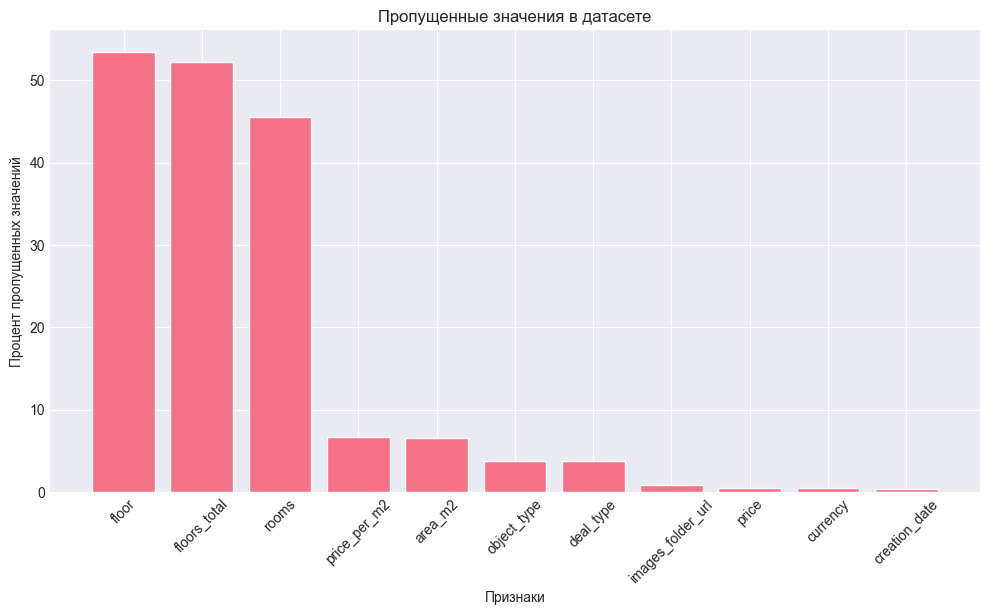

In [71]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})
missing_df = missing_df[missing_df['Количество пропусков'] > 0].sort_values('Процент пропусков', ascending=False)
print(missing_df)

plt.figure(figsize=(12, 6))
plt.bar(missing_df.index, missing_df['Процент пропусков'])
plt.xlabel('Признаки')
plt.ylabel('Процент пропущенных значений')
plt.title('Пропущенные значения в датасете')
plt.xticks(rotation=45)
plt.show()

### Анализ распределения цен *(с обработкой копии датасета по `99%` квантилю сверху)*

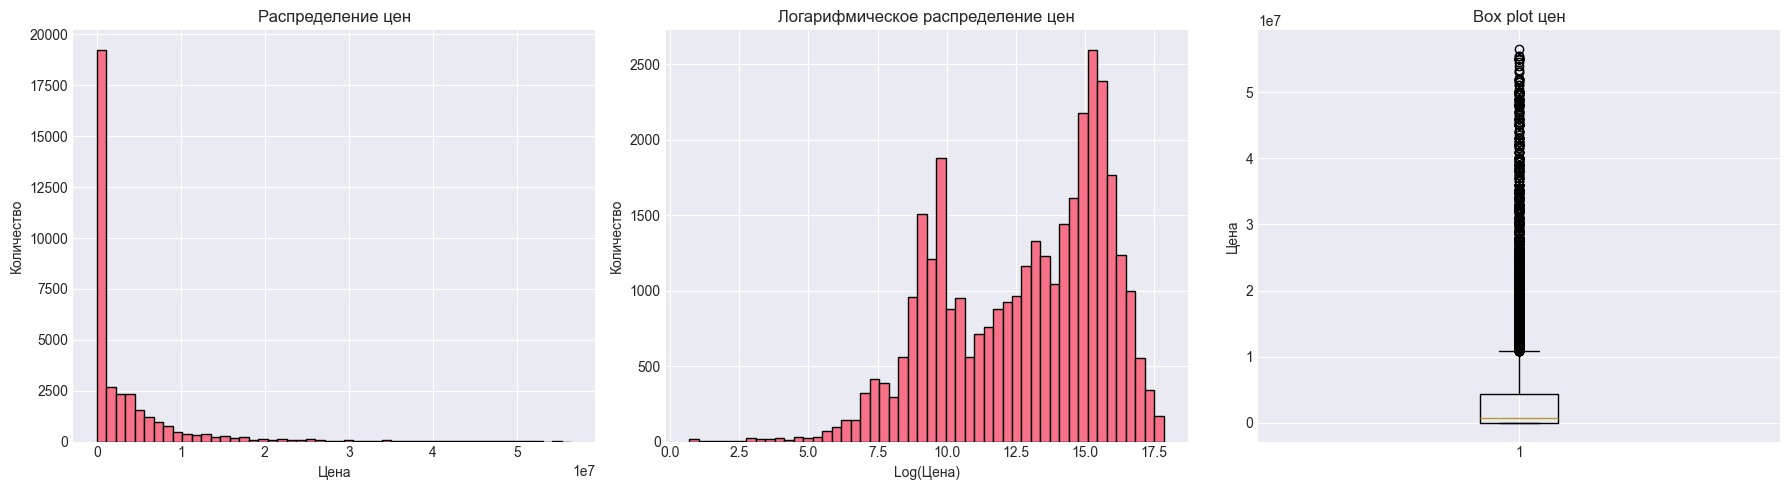

In [72]:
df_analysis = df[(df['price'] > 0) & (df['price'] < df['price'].quantile(0.99))]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df_analysis['price'], bins=50, edgecolor='black')
axes[0].set_xlabel('Цена')
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение цен')

df_analysis['log_price'] = np.log1p(df_analysis['price'])
axes[1].hist(df_analysis['log_price'], bins=50, edgecolor='black')
axes[1].set_xlabel('Log(Цена)')
axes[1].set_ylabel('Количество')
axes[1].set_title('Логарифмическое распределение цен')

axes[2].boxplot(df_analysis['price'])
axes[2].set_ylabel('Цена')
axes[2].set_title('Box plot цен')

plt.tight_layout()
plt.show()

### Анализ распределения категориальных признаков

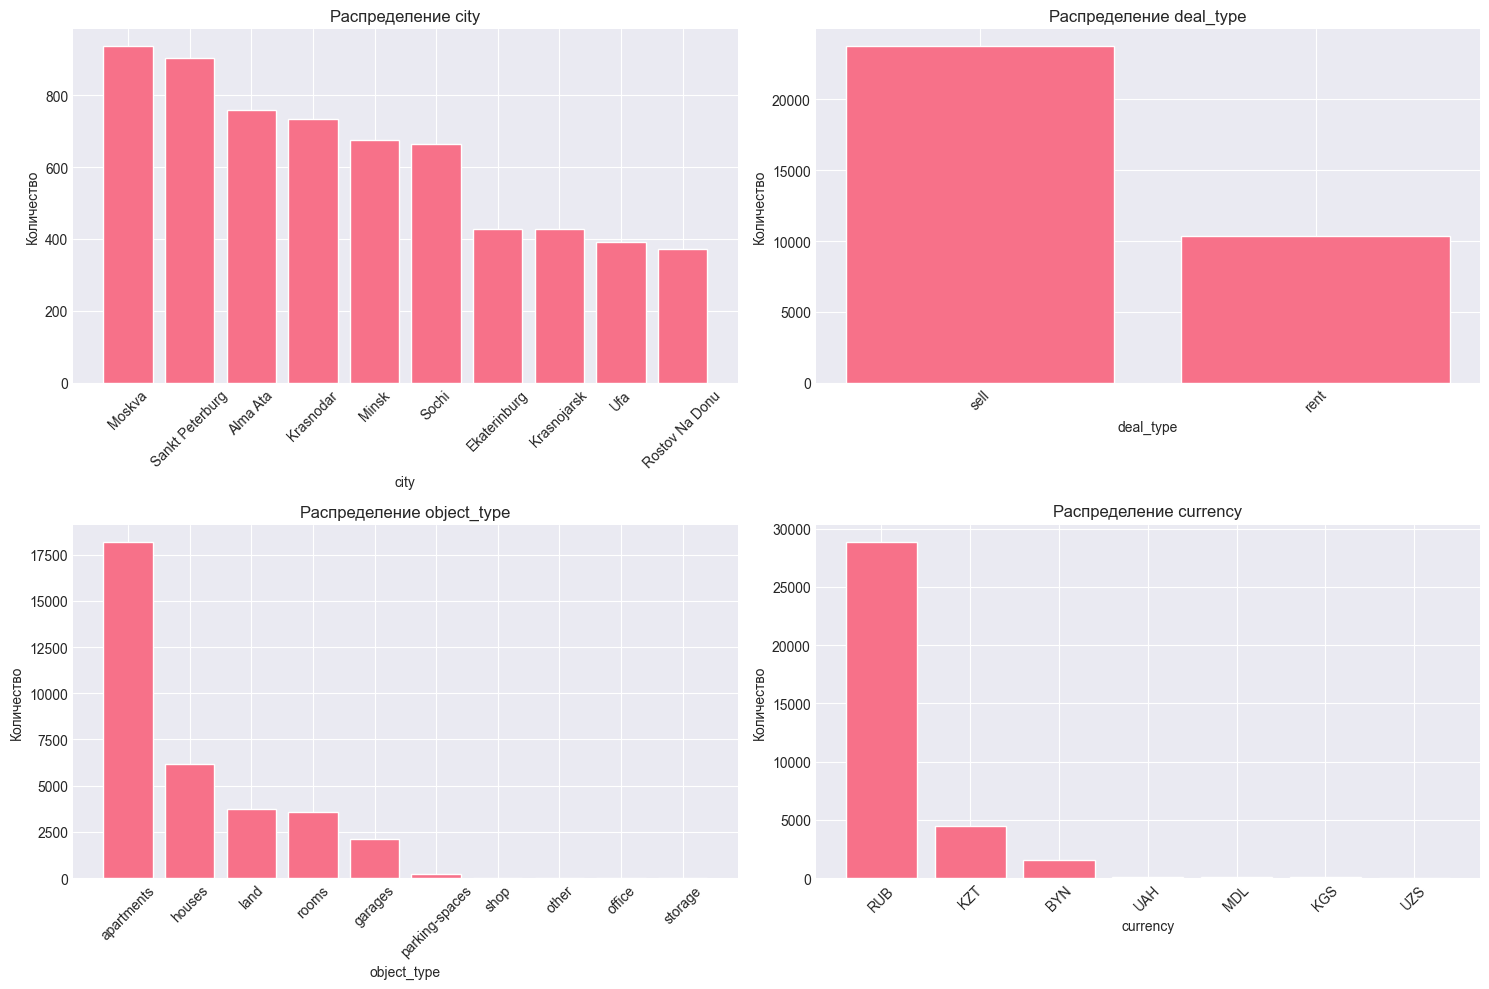

In [73]:
categorical_features = ['city', 'deal_type', 'object_type', 'currency']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    value_counts = df[feature].value_counts()
    axes[idx].bar(value_counts.index[:10], value_counts.values[:10])
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Количество')
    axes[idx].set_title(f'Распределение {feature}')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Анализ зависимости цены от различных факторов и средние значения

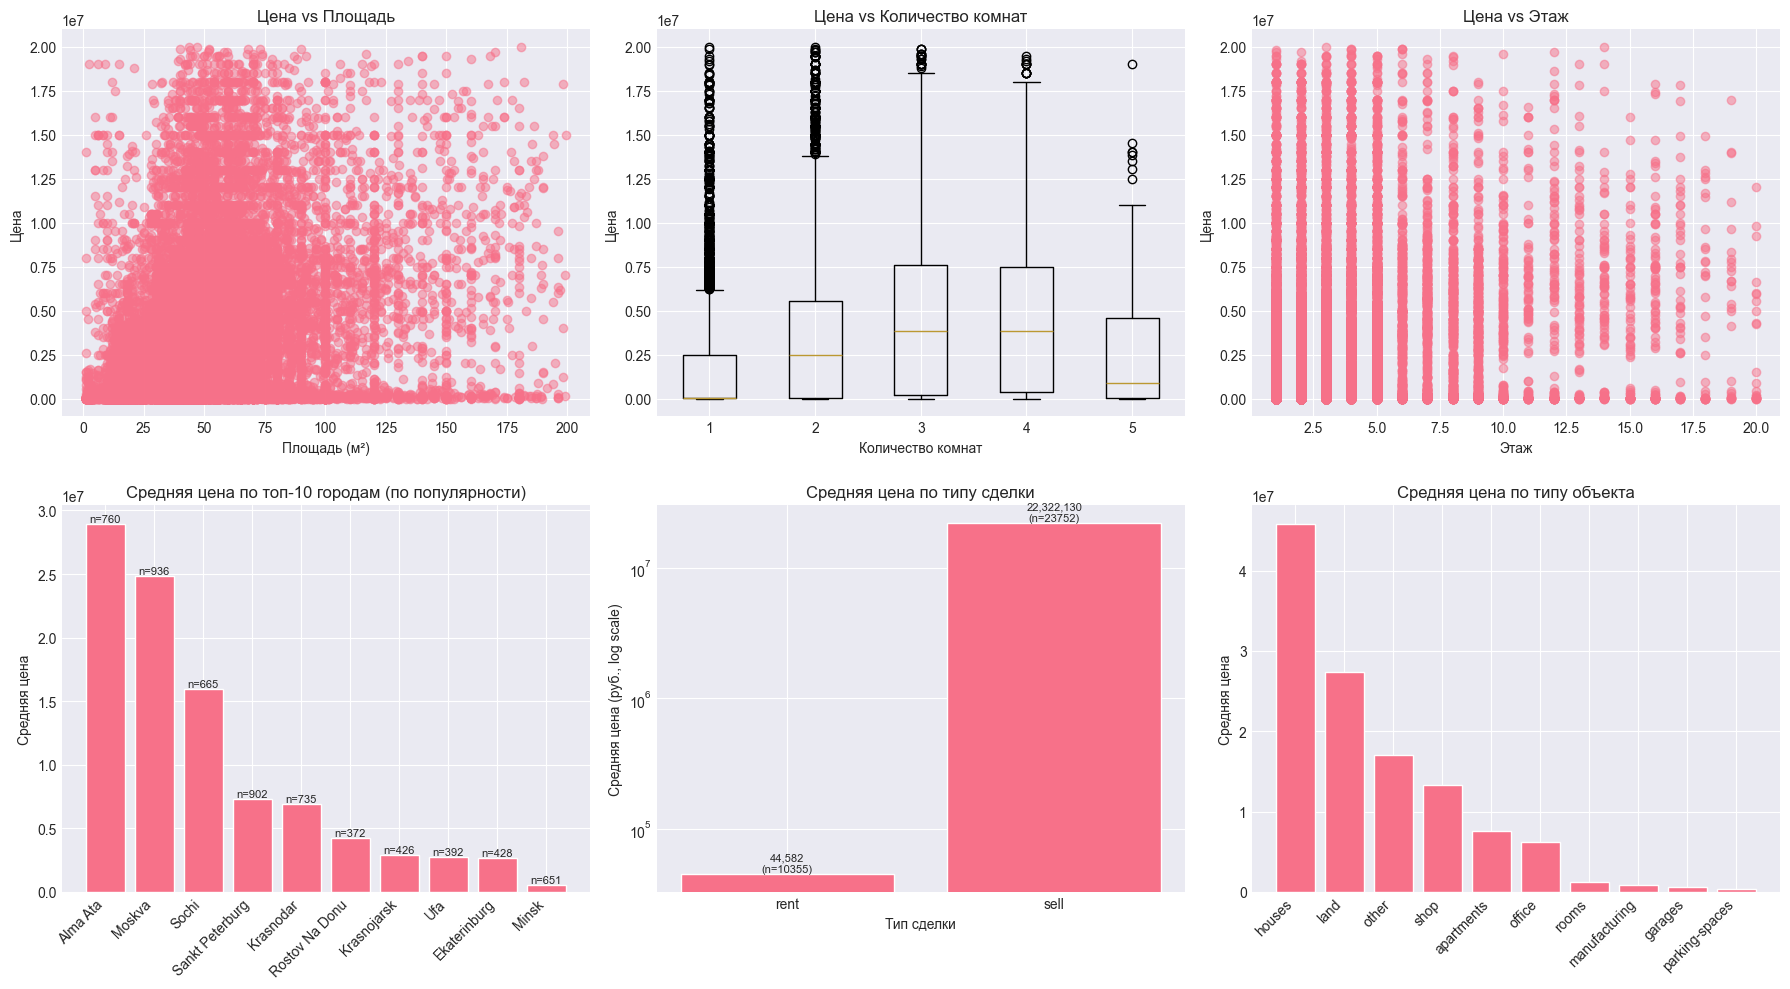

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Цена vs Площадь
df_plot = df[(df['area_m2'] > 0) & (df['area_m2'] < 200) & (df['price'] < 20000000)]
axes[0, 0].scatter(df_plot['area_m2'], df_plot['price'], alpha=0.5)
axes[0, 0].set_xlabel('Площадь (м²)')
axes[0, 0].set_ylabel('Цена')
axes[0, 0].set_title('Цена vs Площадь')

# Цена vs Кол-во комнат
df_rooms = df[df['rooms'].notna() & (df['price'] < 20000000)]
axes[0, 1].boxplot([df_rooms[df_rooms['rooms'] == i]['price'].values
                     for i in sorted(df_rooms['rooms'].unique()) if i <= 5])
axes[0, 1].set_xlabel('Количество комнат')
axes[0, 1].set_ylabel('Цена')
axes[0, 1].set_title('Цена vs Количество комнат')

# Цена vs Этаж
df_floor = df[df['floor'].notna() & (df['price'] < 20000000) & (df['floor'] <= 20)]
axes[0, 2].scatter(df_floor['floor'], df_floor['price'], alpha=0.5)
axes[0, 2].set_xlabel('Этаж')
axes[0, 2].set_ylabel('Цена')
axes[0, 2].set_title('Цена vs Этаж')

# Средняя цена по топ 10 городам (по кол-ву объявлений)
top_cities = df['city'].value_counts().head(10).index
city_data = df[df['city'].isin(top_cities)].groupby('city').agg({
    'price': ['mean', 'count']
})
city_data.columns = ['mean_price', 'count']
city_data = city_data.sort_values('mean_price', ascending=False)

axes[1, 0].bar(range(len(city_data)), city_data['mean_price'].values)
axes[1, 0].set_xticks(range(len(city_data)))
axes[1, 0].set_xticklabels(city_data.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Средняя цена')
axes[1, 0].set_title('Средняя цена по топ-10 городам (по популярности)')

for i, (city, row) in enumerate(city_data.iterrows()):
    axes[1, 0].text(i, row['mean_price'], f"n={int(row['count'])}",
                    ha='center', va='bottom', fontsize=8, rotation=0)

# Цена по типу сделки
deal_prices = df.groupby('deal_type')['price'].mean()
deal_counts = df.groupby('deal_type').size()

axes[1, 1].bar(deal_prices.index, deal_prices.values)
axes[1, 1].set_xlabel('Тип сделки')
axes[1, 1].set_ylabel('Средняя цена (руб., log scale)')
axes[1, 1].set_title('Средняя цена по типу сделки')
axes[1, 1].set_yscale('log')

for i, (deal_type, price) in enumerate(deal_prices.items()):
    count = deal_counts[deal_type]
    axes[1, 1].text(i, price, f'{price:,.0f}\n(n={count})',
                    ha='center', va='bottom', fontsize=8)

# Цена по типу объекта
object_prices = df.groupby('object_type')['price'].mean().sort_values(ascending=False)[:10]
axes[1, 2].bar(range(len(object_prices)), object_prices.values)
axes[1, 2].set_xticks(range(len(object_prices)))
axes[1, 2].set_xticklabels(object_prices.index, rotation=45, ha='right')
axes[1, 2].set_ylabel('Средняя цена')
axes[1, 2].set_title('Средняя цена по типу объекта')

plt.tight_layout()
plt.show()

### Фильтрация данных и обработка выбросов *(по 95% квантилю, обрезая по 2,5% снизу и сверху)*

In [75]:
df_processed = df.copy()

df_processed = df_processed[df_processed['price'].notna()]
df_processed = df_processed[df_processed['price'] > 0]
df_processed = df_processed[df_processed['currency'] == 'RUB']

Q1 = df_processed['price'].quantile(0.025)
Q3 = df_processed['price'].quantile(0.975)
df_processed = df_processed[(df_processed['price'] >= Q1) & (df_processed['price'] <= Q3)]

df_processed = df_processed[(df_processed['area_m2'] > 10) & (df_processed['area_m2'] < 300)]

if 'price_per_m2' in df_processed.columns:
    price_per_m2_q1 = df_processed['price_per_m2'].quantile(0.025)
    price_per_m2_q3 = df_processed['price_per_m2'].quantile(0.975)
    df_processed = df_processed[(df_processed['price_per_m2'] >= price_per_m2_q1) &
                                (df_processed['price_per_m2'] <= price_per_m2_q3)]

df_processed = df_processed[df_processed['rooms'] <= 10]
df_processed = df_processed[df_processed['floor'] <= 50]
df_processed = df_processed[df_processed['floors_total'] <= 50]

print(f"Размер датасета после фильтрации: {df_processed.shape}")
print(f"Статистика цен после фильтрации:")
print(f"Минимум: {df_processed['price'].min():,.0f}")
print(f"Максимум: {df_processed['price'].max():,.0f}")
print(f"Среднее: {df_processed['price'].mean():,.0f}")
print(f"Медиана: {df_processed['price'].median():,.0f}")

Размер датасета после фильтрации: (9422, 14)
Статистика цен после фильтрации:
Минимум: 1,500
Максимум: 19,000,000
Среднее: 3,740,332
Медиана: 3,400,000


### Заполнение пропусков медианой

In [76]:
numerical_features = ['rooms', 'floor', 'floors_total', 'area_m2', 'price_per_m2']

for feature in numerical_features:
    if feature in df_processed.columns:
        df_processed[feature] = df_processed.groupby('object_type')[feature].transform(
            lambda x: x.fillna(x.median())
        )
        df_processed[feature].fillna(df_processed[feature].median(), inplace=True)

print("Пропущенные значения после обработки:")
print(df_processed[numerical_features].isnull().sum())

Пропущенные значения после обработки:
rooms           0
floor           0
floors_total    0
area_m2         0
price_per_m2    0
dtype: int64


### Создание новых признаков

In [77]:
df_processed['floor_ratio'] = df_processed['floor'] / df_processed['floors_total']
df_processed['floor_ratio'].fillna(0.5, inplace=True)

df_processed['is_first_floor'] = (df_processed['floor'] == 1).astype(int)
df_processed['is_last_floor'] = (df_processed['floor'] == df_processed['floors_total']).astype(int)

df_processed['area_per_room'] = df_processed['area_m2'] / df_processed['rooms']
df_processed['area_per_room'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_processed['area_per_room'].fillna(df_processed['area_per_room'].median(), inplace=True)

df_processed['creation_date'] = pd.to_datetime(df_processed['creation_date'], format='%d.%m.%Y', errors='coerce')
df_processed['year'] = df_processed['creation_date'].dt.year
df_processed['month'] = df_processed['creation_date'].dt.month
df_processed['day_of_week'] = df_processed['creation_date'].dt.dayofweek

df_processed['urgent_tag'] = df_processed['urgent_tag'].astype(int)

### Кодирование категориальных переменных (Binary Encoding) и сравнение с One-Hot Encoding

In [78]:
categorical_columns = ['city', 'deal_type', 'object_type']

if all(col in df_processed.columns for col in categorical_columns):
    print("Уникальные значения в категориальных признаках:")
    for col in categorical_columns:
        print(f"  {col}: {df_processed[col].nunique()}")

    df_processed_original_cats = df_processed[categorical_columns].copy()

    binary_encoder = BinaryEncoder(cols=categorical_columns)
    df_encoded = binary_encoder.fit_transform(df_processed[categorical_columns])

    df_processed = df_processed.drop(columns=categorical_columns)
    df_processed = pd.concat([df_processed, df_encoded], axis=1)

    print(f"Новые столбцы после кодирования: {list(df_encoded.columns)}")
    print(f"Количество новых столбцов: {len(df_encoded.columns)}")
    print(f"\nСравнение:")
    print(f"  Binary Encoding: {len(df_encoded.columns)} столбцов")
    estimated_onehot = sum([df_processed_original_cats[col].nunique() - 1 for col in categorical_columns])
    print(f"  One-Hot Encoding создало бы: ~{estimated_onehot} столбцов")


Уникальные значения в категориальных признаках:
  city: 833
  deal_type: 2
  object_type: 2
Новые столбцы после кодирования: ['city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'deal_type_0', 'deal_type_1', 'object_type_0', 'object_type_1']
Количество новых столбцов: 14

Сравнение:
  Binary Encoding: 14 столбцов
  One-Hot Encoding создало бы: ~834 столбцов


### Подготовка данных после кодирования

In [79]:
binary_encoded_columns = [col for col in df_processed.columns if any(cat in col for cat in categorical_columns)]

feature_columns = [
    'rooms', 'floor', 'floors_total', 'area_m2',
    'floor_ratio', 'is_first_floor', 'is_last_floor', 'area_per_room',
    'year', 'month', 'day_of_week', 'urgent_tag'
] + binary_encoded_columns

df_final = df_processed[feature_columns + ['price']].dropna()

ds = df_final[feature_columns]

print(f"Финальный размер датасета: {ds.shape[0]} объектов, {ds.shape[1]} признаков")
print(f"Из них binary encoded: {len(binary_encoded_columns)} признаков")

Финальный размер датасета: 9422 объектов, 26 признаков
Из них binary encoded: 14 признаков


### Baseline модель *(с price_per_m2)*

Train размер: (7537, 4)
Test размер: (1885, 4)
Baseline метрики (price_per_m2 * area):
----------------------------------------------------------------------
MAE: 1,495,038 руб.
RMSE: 2,309,511 руб.
R²: 0.4510
----------------------------------------------------------------------

Статистика ошибок:
Средняя ошибка: -244,733 руб.
Медианная абсолютная ошибка: 890,127 руб.
Процент предсказаний с ошибкой < 1 млн: 53.5%
Процент предсказаний с ошибкой < 500k: 32.7%


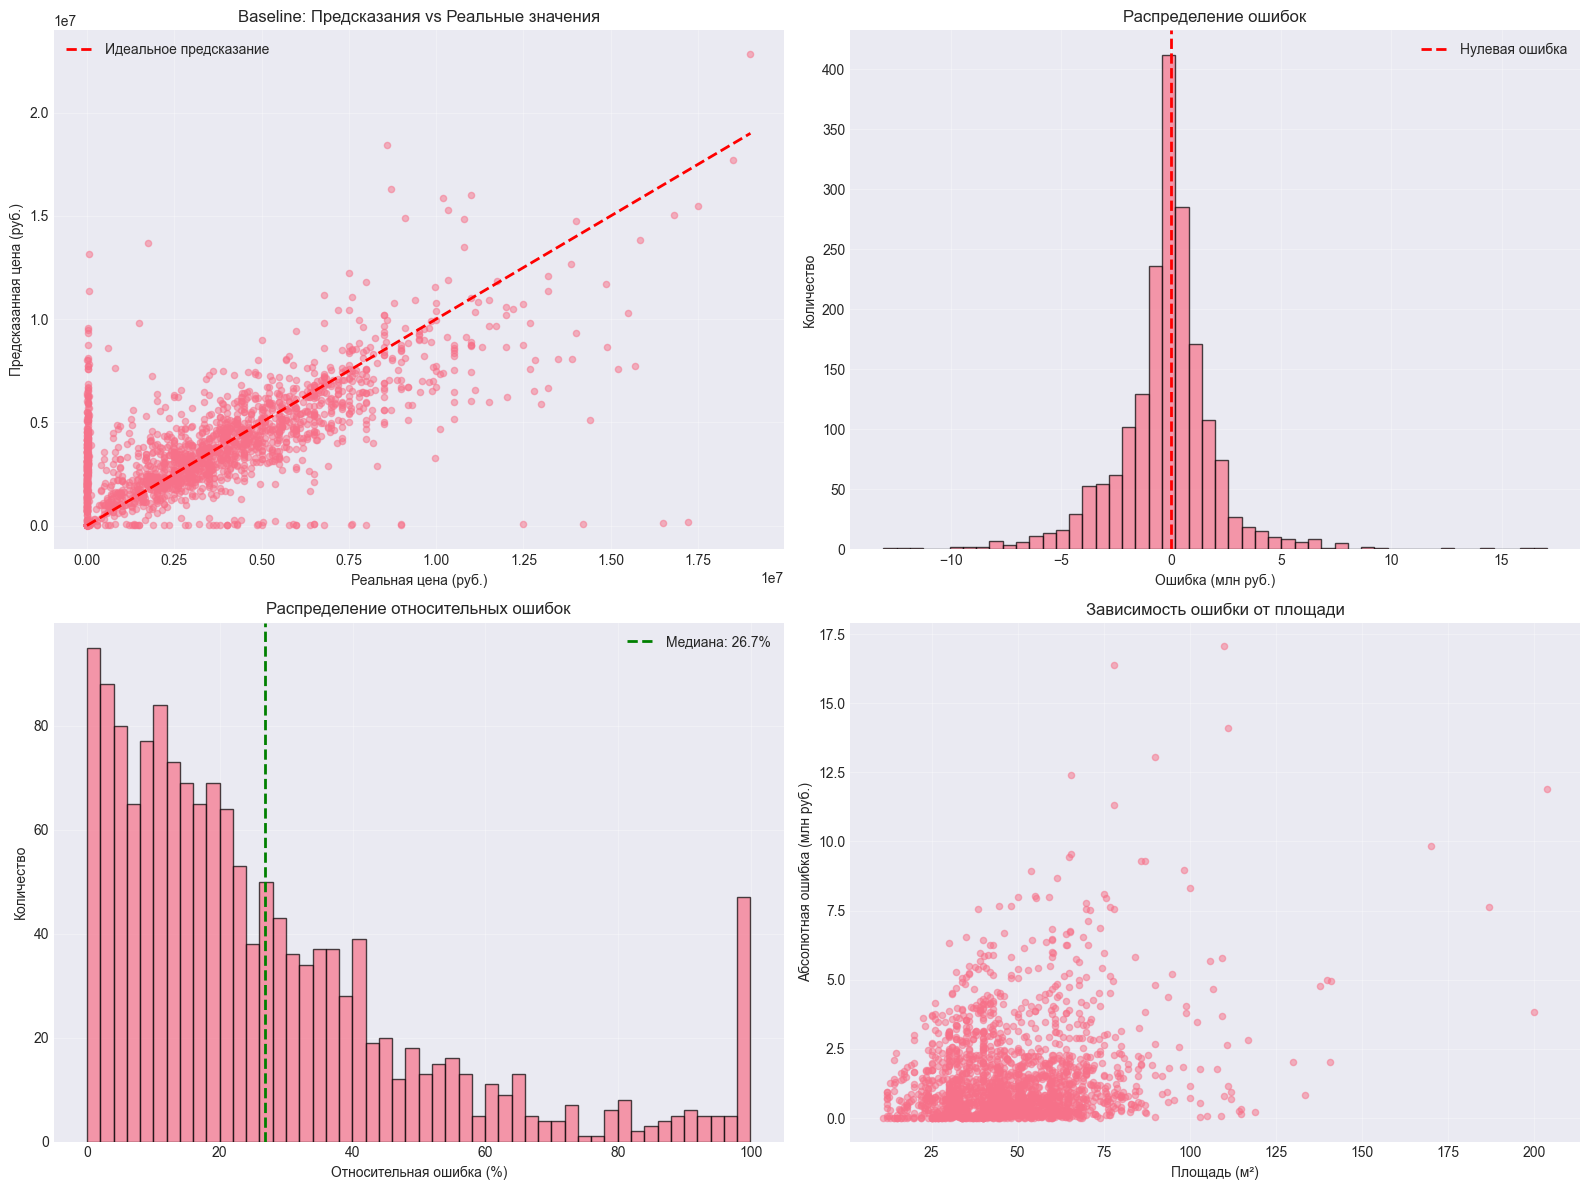

Анализ ошибок по топ-5 городам:
----------------------------------------------------------------------
                 Средняя ошибка  Медианная ошибка  Количество
city                                                         
Krasnodar             2214695.0         1194764.0          60
Sankt Peterburg       2869059.0         1698723.0          60
Ekaterinburg          1951797.0         1394176.0          42
Sochi                 2035064.0         1285957.0          38
Ufa                   1339999.0          733061.0          37


In [80]:
df_baseline = pd.DataFrame({
    'city': df_processed_original_cats['city'],
    'object_type': df_processed_original_cats['object_type'],
    'price': df_processed['price'],
    'area_m2': df_processed['area_m2']
})
df_baseline = df_baseline.dropna()

train_df, test_df = train_test_split(df_baseline, test_size=0.2, random_state=42)

print(f"Train размер: {train_df.shape}")
print(f"Test размер: {test_df.shape}")

train_df['price_per_m2'] = train_df['price'] / train_df['area_m2']

train_price_per_m2_by_city_object = train_df.groupby(['city', 'object_type'])['price_per_m2'].median()
train_price_per_m2_by_city = train_df.groupby('city')['price_per_m2'].median()
train_overall_price_per_m2 = train_df['price_per_m2'].median()

def baseline_predict(row, price_per_m2_by_city_object, price_per_m2_by_city, overall_price_per_m2):
    """предсказание на основе медианной цены за м² * площадь"""
    area = row['area_m2']

    if (row['city'], row['object_type']) in price_per_m2_by_city_object.index:
        price_per_m2 = price_per_m2_by_city_object[row['city'], row['object_type']]
        return price_per_m2 * area
    elif row['city'] in price_per_m2_by_city.index:
        price_per_m2 = price_per_m2_by_city[row['city']]
        return price_per_m2 * area
    else:
        return overall_price_per_m2 * area

test_df['baseline_pred'] = test_df.apply(
    lambda row: baseline_predict(row, train_price_per_m2_by_city_object,
                                 train_price_per_m2_by_city, train_overall_price_per_m2),
    axis=1
)

baseline_mae = mean_absolute_error(test_df['price'], test_df['baseline_pred'])
baseline_rmse = np.sqrt(mean_squared_error(test_df['price'], test_df['baseline_pred']))
baseline_r2 = r2_score(test_df['price'], test_df['baseline_pred'])

print("Baseline метрики (price_per_m2 * area):")
print("-"*70)
print(f"MAE: {baseline_mae:,.0f} руб.")
print(f"RMSE: {baseline_rmse:,.0f} руб.")
print(f"R²: {baseline_r2:.4f}")
print("-"*70)

errors = test_df['price'] - test_df['baseline_pred']
print(f"\nСтатистика ошибок:")
print(f"Средняя ошибка: {errors.mean():,.0f} руб.")
print(f"Медианная абсолютная ошибка: {errors.abs().median():,.0f} руб.")
print(f"Процент предсказаний с ошибкой < 1 млн: {(errors.abs() < 1000000).sum() / len(errors) * 100:.1f}%")
print(f"Процент предсказаний с ошибкой < 500k: {(errors.abs() < 500000).sum() / len(errors) * 100:.1f}%")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].scatter(test_df['price'], test_df['baseline_pred'], alpha=0.5, s=20)
axes[0, 0].plot([test_df['price'].min(), test_df['price'].max()],
                [test_df['price'].min(), test_df['price'].max()],
                'r--', linewidth=2, label='Идеальное предсказание')
axes[0, 0].set_xlabel('Реальная цена (руб.)')
axes[0, 0].set_ylabel('Предсказанная цена (руб.)')
axes[0, 0].set_title('Baseline: Предсказания vs Реальные значения')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(errors / 1000000, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Ошибка (млн руб.)')
axes[0, 1].set_ylabel('Количество')
axes[0, 1].set_title('Распределение ошибок')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Нулевая ошибка')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

relative_errors = (errors.abs() / test_df['price']) * 100
axes[1, 0].hist(relative_errors[relative_errors < 100], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Относительная ошибка (%)')
axes[1, 0].set_ylabel('Количество')
axes[1, 0].set_title('Распределение относительных ошибок')
axes[1, 0].axvline(x=relative_errors.median(), color='g', linestyle='--',
                   linewidth=2, label=f'Медиана: {relative_errors.median():.1f}%')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(test_df['area_m2'], errors.abs() / 1000000, alpha=0.5, s=20)
axes[1, 1].set_xlabel('Площадь (м²)')
axes[1, 1].set_ylabel('Абсолютная ошибка (млн руб.)')
axes[1, 1].set_title('Зависимость ошибки от площади')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Анализ ошибок по топ-5 городам:")
print("-"*70)
test_df['abs_error'] = errors.abs()
city_errors = test_df.groupby('city').agg({
    'abs_error': ['mean', 'median', 'count']
}).round(0)
city_errors.columns = ['Средняя ошибка', 'Медианная ошибка', 'Количество']
city_errors = city_errors.sort_values('Количество', ascending=False).head()
print(city_errors)

### Разделение данных на Train | Validation | Test *(`60`% | `20`% | `20`%)* и нормализация признаков

In [81]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Размеры данных для обучения моделей:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Размеры данных для обучения моделей:
X_train: (5652, 26), y_train: (5652,) (60.0%)
X_val: (1885, 26), y_val: (1885,) (20.0%)
X_test: (1885, 26), y_test: (1885,) (20.0%)


### Модель №1: *Linear Regression*

In [82]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_train_pred_lr = lr_model.predict(X_train_scaled)
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)

val_mae_lr = mean_absolute_error(y_val, y_val_pred_lr)
val_rmse_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
val_r2_lr = r2_score(y_val, y_val_pred_lr)

test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print("\nLinear Regression - Train метрики:")
print(f"MAE: {train_mae_lr:,.0f} руб.")
print(f"RMSE: {train_rmse_lr:,.0f} руб.")
print(f"R²: {train_r2_lr:.4f}")

print("\nLinear Regression - Validation метрики:")
print(f"MAE: {val_mae_lr:,.0f} руб.")
print(f"RMSE: {val_rmse_lr:,.0f} руб.")
print(f"R²: {val_r2_lr:.4f}")

print("\nLinear Regression - Test метрики:")
print(f"MAE: {test_mae_lr:,.0f} руб.")
print(f"RMSE: {test_rmse_lr:,.0f} руб.")
print(f"R²: {test_r2_lr:.4f}")

feature_importance_lr = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': np.abs(lr_model.coef_)
}).sort_values('coefficient', ascending=False)

print("\nТоп-10 важных признаков (Linear Regression):")
print(feature_importance_lr.head(10))



Linear Regression - Train метрики:
MAE: 1,462,662 руб.
RMSE: 1,971,656 руб.
R²: 0.5958

Linear Regression - Validation метрики:
MAE: 1,486,040 руб.
RMSE: 2,232,720 руб.
R²: 0.5091

Linear Regression - Test метрики:
MAE: 1,469,231 руб.
RMSE: 1,988,154 руб.
R²: 0.5932

Топ-10 важных признаков (Linear Regression):
           feature   coefficient
3          area_m2  1.521172e+06
22     deal_type_0  7.380179e+05
23     deal_type_1  7.380179e+05
2     floors_total  3.971646e+05
12          city_0  3.328582e+05
4      floor_ratio  3.056361e+05
13          city_1  2.698016e+05
1            floor  2.414066e+05
0            rooms  2.373265e+05
5   is_first_floor  2.186008e+05


### Модель №2: *Random Forest*

In [83]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)

val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
val_r2_rf = r2_score(y_val, y_val_pred_rf)

test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\nRandom Forest - Train метрики:")
print(f"MAE: {train_mae_rf:,.0f} руб.")
print(f"RMSE: {train_rmse_rf:,.0f} руб.")
print(f"R²: {train_r2_rf:.4f}")

print("\nRandom Forest - Validation метрики:")
print(f"MAE: {val_mae_rf:,.0f} руб.")
print(f"RMSE: {val_rmse_rf:,.0f} руб.")
print(f"R²: {val_r2_rf:.4f}")

print("\nRandom Forest - Test метрики:")
print(f"MAE: {test_mae_rf:,.0f} руб.")
print(f"RMSE: {test_rmse_rf:,.0f} руб.")
print(f"R²: {test_r2_rf:.4f}")

feature_importance_rf = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-10 важных признаков (Random Forest):")
print(feature_importance_rf.head(10))



Random Forest - Train метрики:
MAE: 586,503 руб.
RMSE: 913,964 руб.
R²: 0.9131

Random Forest - Validation метрики:
MAE: 1,181,387 руб.
RMSE: 1,835,405 руб.
R²: 0.6683

Random Forest - Test метрики:
MAE: 1,159,046 руб.
RMSE: 1,781,013 руб.
R²: 0.6735

Топ-10 важных признаков (Random Forest):
          feature  importance
3         area_m2    0.293036
22    deal_type_0    0.159550
23    deal_type_1    0.147566
2    floors_total    0.129007
7   area_per_room    0.060815
4     floor_ratio    0.024186
1           floor    0.016284
13         city_1    0.014639
9           month    0.013809
15         city_3    0.013514


### Подбор гиперпараметров для Random Forest *(GridSearchCV)*

In [84]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Результаты GridSearchCV:")
print("-"*70)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший CV score (MAE): {-grid_search.best_score_:,.0f} руб.")
print("-"*70)

rf_model_tuned = grid_search.best_estimator_

y_train_pred_rf_tuned = rf_model_tuned.predict(X_train)
y_val_pred_rf_tuned = rf_model_tuned.predict(X_val)
y_test_pred_rf_tuned = rf_model_tuned.predict(X_test)

print("Random Forest (после GridSearch) - Метрики:")
print("-"*70)

for name, y_true, y_pred in [('Train', y_train, y_train_pred_rf_tuned),
                              ('Validation', y_val, y_val_pred_rf_tuned),
                              ('Test', y_test, y_test_pred_rf_tuned)]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name}:")
    print(f"  MAE:  {mae:,.0f} руб.")
    print(f"  RMSE: {rmse:,.0f} руб.")
    print(f"  R²:   {r2:.4f}")

print("\n" + "-"*70)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Результаты GridSearchCV:
----------------------------------------------------------------------
Лучшие параметры: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Лучший CV score (MAE): 1,164,224 руб.
----------------------------------------------------------------------
Random Forest (после GridSearch) - Метрики:
----------------------------------------------------------------------

Train:
  MAE:  551,306 руб.
  RMSE: 861,923 руб.
  R²:   0.9228

Validation:
  MAE:  1,180,174 руб.
  RMSE: 1,833,918 руб.
  R²:   0.6688

Test:
  MAE:  1,161,155 руб.
  RMSE: 1,785,687 руб.
  R²:   0.6718

------------------------------------------------------------


### Реализация Custom Decision Tree Regressor

In [85]:
class CustomDecisionTreeRegressor:
    """ Реализация Decision Tree для регрессии
    Гиперпараметры:
    - max_depth: максимальная глубина дерева
    - min_samples_split: минимальное количество объектов для разделения узла
    """

    def __init__(self, max_depth=10, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def get_params(self, deep=True):
        return {
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def _mse(self, y):
        if len(y) == 0:
            return 0
        mean = np.mean(y)
        return np.mean((y - mean) ** 2)

    def _best_split(self, X, y):
        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        n_features = X.shape[1]

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            if len(thresholds) > 10:
                thresholds = np.percentile(X[:, feature], np.linspace(10, 90, 10))

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                left_mse = self._mse(y[left_mask])
                right_mse = self._mse(y[right_mask])

                weighted_mse = (np.sum(left_mask) * left_mse + np.sum(right_mask) * right_mse) / len(y)

                if weighted_mse < best_mse:
                    best_mse = weighted_mse
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)

        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return self.Node(value=np.mean(y))

        feature, threshold = self._best_split(X, y)

        if feature is None:
            return self.Node(value=np.mean(y))

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return self.Node(feature=feature, threshold=threshold,
                        left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        self.tree = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        return np.array([self._predict_sample(x, self.tree) for x in X])

print("\nГиперпараметры:")
print("- max_depth: максимальная глубина дерева")
print("- min_samples_split: минимальное количество объектов для разделения узла")



Гиперпараметры:
- max_depth: максимальная глубина дерева
- min_samples_split: минимальное количество объектов для разделения узла


### Подбор гиперпараметров для Custom Decision Tree Regressor *(GridSearchCV)*

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Результаты GridSearchCV:
----------------------------------------------------------------------
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 50}
Лучший CV score (MAE): 1,300,218 руб.
----------------------------------------------------------------------
Результаты по эпохам (итерации):
----------------------------------------------------------------------
 iteration  max_depth  min_samples_split    train_mae      val_mae      overfit  overfit_pct
         8         10                 50 1.122173e+06 1.300218e+06 1.780453e+05    15.866123
        16         20                 50 1.092768e+06 1.311954e+06 2.191861e+05    20.057884
        12         15                 50 1.092932e+06 1.312098e+06 2.191666e+05    20.053089
         7         10                 20 1.039980e+06 1.329074e+06 2.890941e+05    27.798054
         6         10                 10 9.817652e+05 1.347110e+06 3.653446e+05    37.213029
         4 

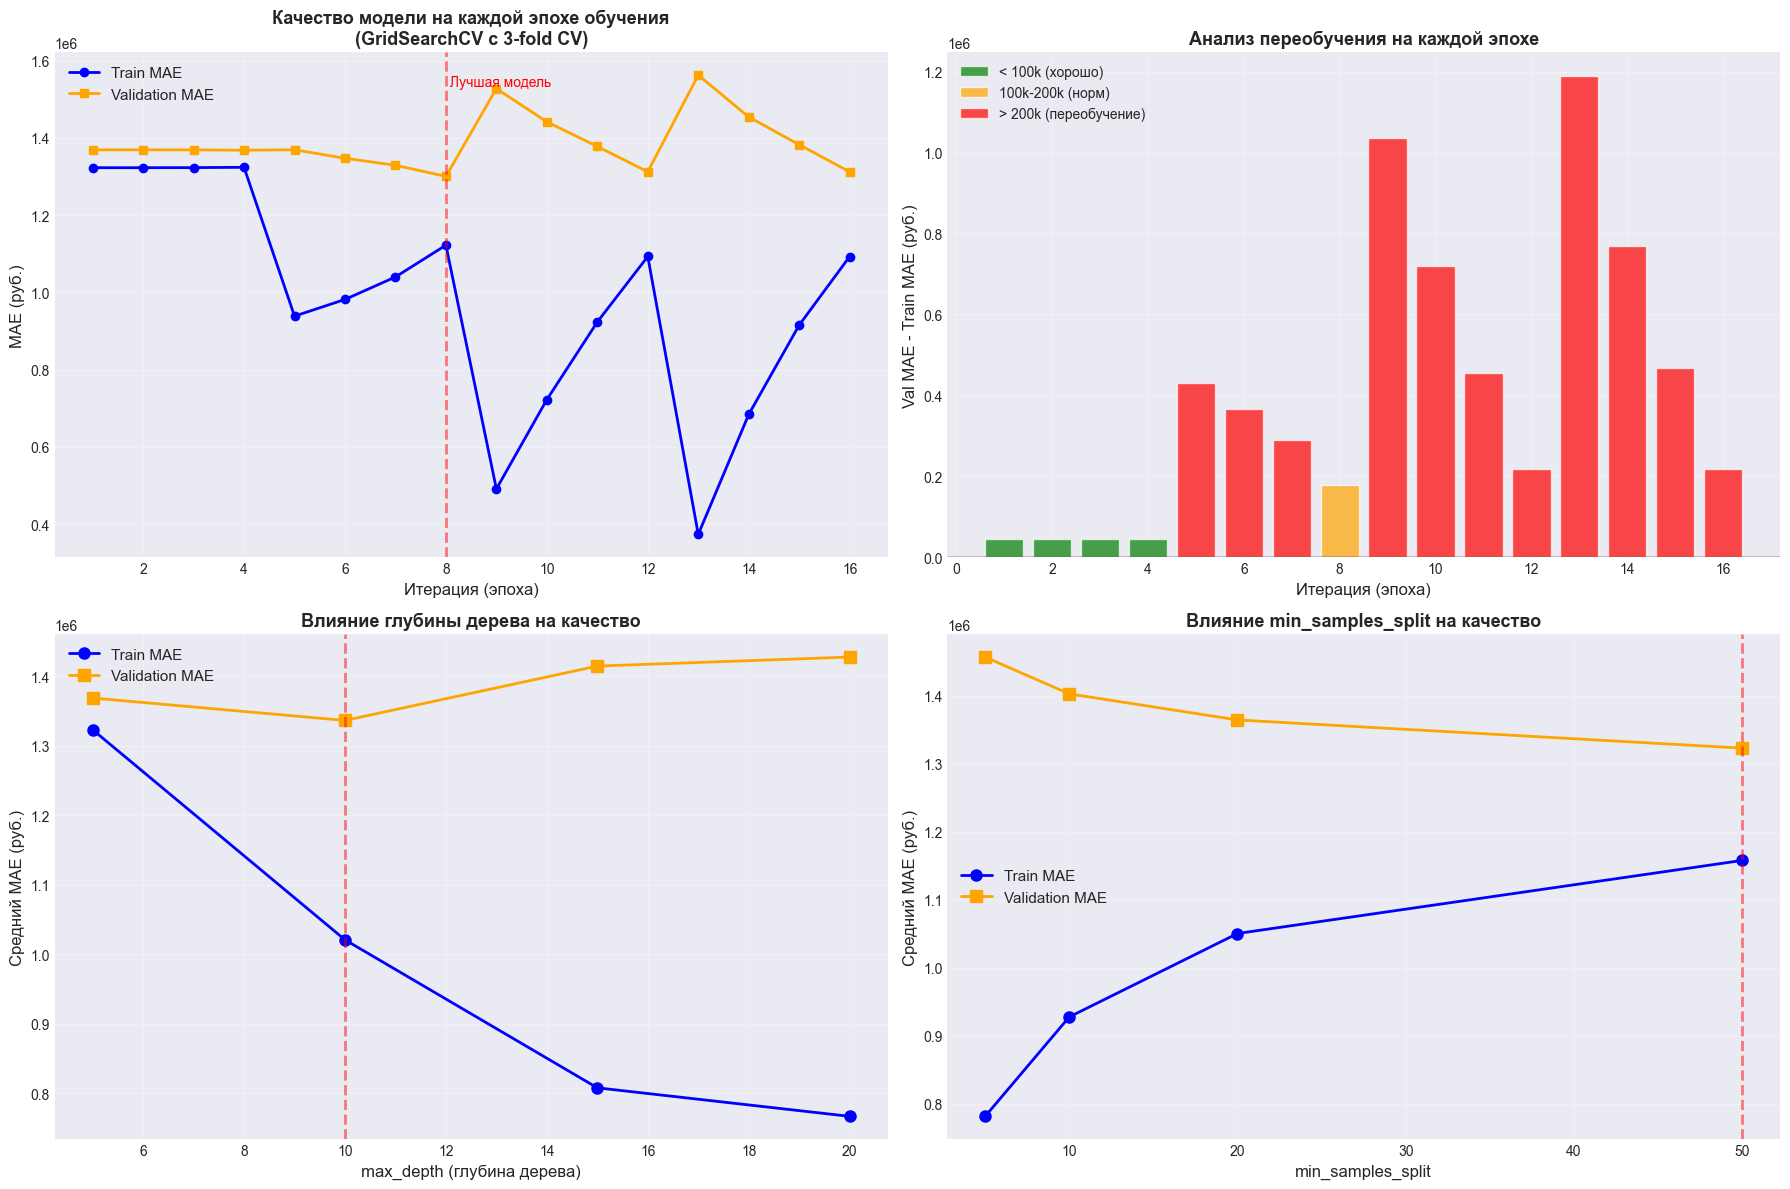


----------------------------------------------------------------------
Лучшая модель сохранена с параметрами:
  max_depth: 10
  min_samples_split: 50
----------------------------------------------------------------------


In [86]:
param_grid_custom = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [5, 10, 20, 50]
}

custom_dt_base = CustomDecisionTreeRegressor()

grid_search_custom = GridSearchCV(
    estimator=custom_dt_base,
    param_grid=param_grid_custom,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

grid_search_custom.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search_custom.cv_results_)

print("Результаты GridSearchCV:")
print("-"*70)
print(f"Лучшие параметры: {grid_search_custom.best_params_}")
print(f"Лучший CV score (MAE): {-grid_search_custom.best_score_:,.0f} руб.")
print("-"*70)

results_detailed = []
for idx, params in enumerate(cv_results['params']):
    train_mae = -cv_results.loc[idx, 'mean_train_score']
    val_mae = -cv_results.loc[idx, 'mean_test_score']
    
    results_detailed.append({
        'iteration': idx + 1,
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'train_mae': train_mae,
        'val_mae': val_mae,
        'overfit': val_mae - train_mae,
        'overfit_pct': ((val_mae - train_mae) / train_mae * 100) if train_mae > 0 else 0
    })

results_df = pd.DataFrame(results_detailed)
print("Результаты по эпохам (итерации):")
print("-"*70)
print(results_df.sort_values('val_mae').to_string(index=False))
print("-"*70)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# MAE на train и validation по итерациям
iterations = results_df['iteration'].values
train_maes = results_df['train_mae'].values
val_maes = results_df['val_mae'].values

axes[0, 0].plot(iterations, train_maes, 'o-', label='Train MAE', linewidth=2, markersize=6, color='blue')
axes[0, 0].plot(iterations, val_maes, 's-', label='Validation MAE', linewidth=2, markersize=6, color='orange')
axes[0, 0].set_xlabel('Итерация (эпоха)', fontsize=12)
axes[0, 0].set_ylabel('MAE (руб.)', fontsize=12)
axes[0, 0].set_title('Качество модели на каждой эпохе обучения\n(GridSearchCV с 3-fold CV)', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

best_iteration = results_df['val_mae'].idxmin() + 1
axes[0, 0].axvline(x=best_iteration, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[0, 0].text(best_iteration, max(val_maes), ' Лучшая модель', 
                color='red', fontsize=10, verticalalignment='top')

# Разница между train и val MAE (переобучение)
overfit = results_df['overfit'].values
colors = ['green' if o < 100000 else 'orange' if o < 200000 else 'red' for o in overfit]
axes[0, 1].bar(iterations, overfit, color=colors, alpha=0.7)
axes[0, 1].set_xlabel('Итерация (эпоха)', fontsize=12)
axes[0, 1].set_ylabel('Val MAE - Train MAE (руб.)', fontsize=12)
axes[0, 1].set_title('Анализ переобучения на каждой эпохе', fontsize=13, fontweight='bold')
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 1].grid(True, alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='< 100k (хорошо)'),
    Patch(facecolor='orange', alpha=0.7, label='100k-200k (норм)'),
    Patch(facecolor='red', alpha=0.7, label='> 200k (переобучение)')
]
axes[0, 1].legend(handles=legend_elements, fontsize=10)

# Зависимость MAE от max_depth
depth_grouped = results_df.groupby('max_depth').agg({'train_mae': 'mean', 'val_mae': 'mean'})
axes[1, 0].plot(depth_grouped.index, depth_grouped['train_mae'], 'o-', label='Train MAE', 
                linewidth=2, markersize=8, color='blue')
axes[1, 0].plot(depth_grouped.index, depth_grouped['val_mae'], 's-', label='Validation MAE', 
                linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('max_depth (глубина дерева)', fontsize=12)
axes[1, 0].set_ylabel('Средний MAE (руб.)', fontsize=12)
axes[1, 0].set_title('Влияние глубины дерева на качество', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

optimal_depth = grid_search_custom.best_params_['max_depth']
axes[1, 0].axvline(x=optimal_depth, color='red', linestyle='--', linewidth=2, alpha=0.5)

# Зависимость MAE от min_samples_split
split_grouped = results_df.groupby('min_samples_split').agg({'train_mae': 'mean', 'val_mae': 'mean'})
axes[1, 1].plot(split_grouped.index, split_grouped['train_mae'], 'o-', label='Train MAE', 
                linewidth=2, markersize=8, color='blue')
axes[1, 1].plot(split_grouped.index, split_grouped['val_mae'], 's-', label='Validation MAE', 
                linewidth=2, markersize=8, color='orange')
axes[1, 1].set_xlabel('min_samples_split', fontsize=12)
axes[1, 1].set_ylabel('Средний MAE (руб.)', fontsize=12)
axes[1, 1].set_title('Влияние min_samples_split на качество', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

optimal_split = grid_search_custom.best_params_['min_samples_split']
axes[1, 1].axvline(x=optimal_split, color='red', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.show()

best_custom_dt = grid_search_custom.best_estimator_
best_params = grid_search_custom.best_params_
print("\n" + "-"*70)
print("Лучшая модель сохранена с параметрами:")
print(f"  max_depth: {best_params['max_depth']}")
print(f"  min_samples_split: {best_params['min_samples_split']}")
print("-"*70)
